# Fine-tuning on Pre-traied Tabula for Reverse Perturbation Prediction

In this tutorial, we illustrate the finetuning steps for the downstream task reverse perturbation prediction task.

Here we take the Norman dataset, which contains both single- and double- gene perturbation as demonstrated in the paper. Please refer to our preprint for more information regarding the dataset and the task. 

In [1]:
import sys
sys.path.append('..')
import os

import numpy as np
import torch
import wandb
from pytorch_lightning import seed_everything
from pytorch_lightning.loggers.wandb import WandbLogger
from tabula.finetune.tokenizer import GeneVocab
from tabula import logger
from tabula.finetune.setup.perturbation import GenePerturbationPrediction
from tabula.finetune.preprocessor import get_pretrained_model
from tabula.finetune.utils import FinetuneConfig
from gears import PertData

/mnt/first19T/linjh/anaconda3/envs/sctabular/lib/python3.10/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


## Pre-define parameters 
- For detailed finetuning parameters, please refer to and modify the yaml file in ```params['config_path']```
- For model weight, please download from this link: https://drive.google.com/drive/folders/19uG3hmvBZr2Zr4mWgIU-8SQ1dSg8GZuJ?usp=sharing
- For data_params['data_dir'], please download the zip file curated by scGPT from this link: https://drive.google.com/file/d/1TILGPZ9B-Vsxx6_zE79uuB2QO9RZPO-K/view?usp=sharing. Then unzip it and use the path as the directory path.
- For data_params['eval_data_dir'], please download the zip file from this link: https://drive.google.com/file/d/1TILGPZ9B-Vsxx6_zE79uuB2QO9RZPO-K/view?usp=sharing. Then put it to the set data_params['data_dir'] path.

In [2]:
params = {
    'seed': 23,
    'config_path': '../resource/finetune_framework_perturbation.yaml',
    'save_folder': 'finetune_out/reverse_perturbation_norman_test',
    'model_path': '../weight/blood.pth',
    'device': 'cuda:0',  # 'cuda:0' or 'cpu'
}

data_params = {
    'data_dir': '/mnt/first19T/linjh/program/submission/shiyu/reverse_perturb/tabula/tutorials/reverse_norman/norman_ctrl_500/',
    'eval_data_dir': '/mnt/first19T/linjh/program/sctabular/tutorials/perturbation_prediction/data_Gears_norman/',
    'vocab_path': '../resource/vocab.json',
    'batch_size': 64,
    'n_workers': 4
}

if_wandb = True
wandb_params = {
    'key': '644b123473f38af040ef215020d8e45acdf48fda',
    'project': 'Perturbation_tutorial_test',
    'entity': 'sctab-downstream',
    'task': 'reverse_perturbation_test'
}


In [3]:
seed_everything(params['seed'])
os.makedirs(params['save_folder'], exist_ok=True)
finetune_config = FinetuneConfig(seed=params['seed'], config_path=params['config_path'])
finetune_config.set_finetune_param('save_folder', params['save_folder'])
finetune_config.set_finetune_param('if_wandb', if_wandb)
logger.info(f'Configuration loaded from {params["config_path"]}, save finetuning result to {params["save_folder"]}')

Global seed set to 23


Tabula - INFO - Configuration loaded from ../resource/finetune_framework_perturbation.yaml, save finetuning result to finetune_out/reverse_perturbation_norman_test


In [4]:
if if_wandb:
    wandb.login(key=wandb_params['key'])
    wandb.init(project=wandb_params['project'], entity=wandb_params['entity'], name=wandb_params['task'])
    wandb_logger = WandbLogger(project=wandb_params['project'], log_model=False, offline=False)
    logger.info(f'Wandb logging enabled')
else:
    wandb_logger = None
    logger.info(f'Wandb logging disabled')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: jianhuilin2001 (sctab-downstream). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /mnt/first19T/linjh/.netrc
/mnt/first19T/linjh/anaconda3/envs/sctabular/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/mnt/first19T/linjh/anaconda3/envs/sctabular/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


Tabula - INFO - Wandb logging enabled


/mnt/first19T/linjh/anaconda3/envs/sctabular/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [5]:
pert_data = PertData(data_params['data_dir'])
pert_data.load(data_path=data_params['data_dir'])
pert_data.prepare_split(split='no_test', seed=1)
pert_data.set2conditions['train'].remove('ctrl')
pert_data.get_dataloader(batch_size=data_params['batch_size'])

Local copy of pyg dataset is detected. Loading...
/mnt/first19T/linjh/anaconda3/envs/sctabular/lib/python3.10/site-packages/gears/pertdata.py:57: ResourceWarning: unclosed file <_io.BufferedReader name='/mnt/first19T/linjh/program/submission/shiyu/reverse_perturb/tabula/tutorials/reverse_norman/norman_ctrl_500/data_pyg/cell_graphs.pkl'>
  self.dataset_processed = pickle.load(open(dataset_fname, "rb"))
Done!
Local copy of split is detected. Loading...
/mnt/first19T/linjh/anaconda3/envs/sctabular/lib/python3.10/site-packages/gears/pertdata.py:129: ResourceWarning: unclosed file <_io.BufferedReader name='/mnt/first19T/linjh/program/submission/shiyu/reverse_perturb/tabula/tutorials/reverse_norman/norman_ctrl_500/splits/_no_test_1_0.75.pkl'>
  set2conditions = pickle.load(open(split_path, "rb"))
Done!
Creating dataloaders....
/mnt/first19T/linjh/anaconda3/envs/sctabular/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.

In [6]:
pert_data_eval = PertData(data_params['eval_data_dir'])
pert_data_eval.load(data_name="norman")
pert_data_eval.prepare_split(split="simulation", seed=1)

Found local copy...
/mnt/first19T/linjh/anaconda3/envs/sctabular/lib/python3.10/site-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/mnt/first19T/linjh/anaconda3/envs/sctabular/lib/python3.10/site-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/mnt/first19T/linjh/anaconda3/envs/sctabular/lib/python3.10/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/__categories/condition' was written without encoding metadata.
  return func(*args, **kwargs)
/mnt/first19T/linjh/anaconda3/envs/sctabular/lib/python3.10/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/condition' was written without encoding metadata.
  return func(*args, **kwargs)
/mnt/first19T/linjh/anaconda3/envs

In [7]:
vocab = GeneVocab.from_file(data_params['vocab_path'])
genes = pert_data.adata.var["gene_name"].tolist()
for gene in genes:
    if gene not in vocab:
        vocab.expand_token(gene)

gene_ids = np.array(
    [vocab[gene] if gene in vocab else vocab["<pad>"] for gene in genes], dtype=int
)

finetune_config.set_model_param('embedding_in_feature', len(vocab))
finetune_config.set_model_param('in_feature', len(gene_ids))
finetune_config.set_model_param('reconstruction_out_feature', len(gene_ids))
logger.info(f'Embedding feature size after expanding vocab: {len(vocab)}')
logger.info(f'Model input feature length is: {len(gene_ids)}')

Tabula - INFO - Embedding feature size after expanding vocab: 61195
Tabula - INFO - Model input feature length is: 5045


## Load pre-trained Tabula

In [8]:
if params['device'] != 'cpu' and not torch.cuda.is_available():
    logger.error(f'Cuda is not available, change device to cpu')
    params['device'] = 'cpu'
tabula_pl_model = get_pretrained_model(
    finetune_config=finetune_config,
    model_path=params['model_path'],
    device=params['device'],
)

Tabula - INFO - Loading FlashAttention Tabula from path: ../weight/blood.pth


/mnt/first19T/linjh/anaconda3/envs/sctabular/lib/python3.10/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Tabula - ERROR - Error loading model from path: ../weight/blood.pth, switch to load specific weights.
Tabula - INFO - Loading params feature_tokenizer.gene_encoder.enc_norm.weight with shape torch.Size([192])
Tabula - INFO - Loading params feature_tokenizer.gene_encoder.enc_norm.bias with shape torch.Size([192])
Tabula - INFO - Loading params feature_tokenizer.value_encoder.enc_norm.weight with shape torch.Size([192])
Tabula - INFO - Loading params feature_tokenizer.value_encoder.enc_norm.bias with shape torch.Size([192])
Tabula - INFO - Loading params bn.weight with shape torch.Size([192])
Tabula - INFO - Loading params bn.bias with shape torch.Size([192])
Tabula - INFO - Loading params bn.running_mean with shape torch.Size([192])
Tabula - INFO - Loading params bn.running_var with shape torch.Size([192])
Tabula - INFO - Loading params bn.num_batches_tracked with shape torch.Size([])
Tabula - INFO - Loading params cls.weight with shape torch.Size([1, 192])
Tabula - INFO - Loading param

## Fine-tune Tabula

Global seed set to 23


Tabula - INFO - Finetune method: light. Max epochs: 1


/mnt/first19T/linjh/anaconda3/envs/sctabular/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type              | Params
------------------

Sanity Checking: 0it [00:00, ?it/s]

/mnt/first19T/linjh/anaconda3/envs/sctabular/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/mnt/first19T/linjh/anaconda3/envs/sctabular/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/first19T/linjh/anaconda3/envs/sctabular/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:83: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 322880. To avoid any miscalculations, use 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/mnt/first19T/linjh/anaconda3/envs/sctabular/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:83: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 95855. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
`Trainer.fit` stopped: `max_epochs=1` reached.


Tabula - INFO - Start evaluating reverse perturbation...
39/210 train conditions, 3/210 valid conditions, and 7/210 test conditions.
Tabula - INFO - Start predicting perturbation...


100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


Processing top 1
Processing top 2
Processing top 3
Processing top 4
Processing top 5
Processing top 6
Processing top 7
Processing top 8
Processing top 9
Processing top 10
Processing top 11
Processing top 12
Processing top 13
Processing top 14
Processing top 15
Tabula - INFO - Finetune finished.


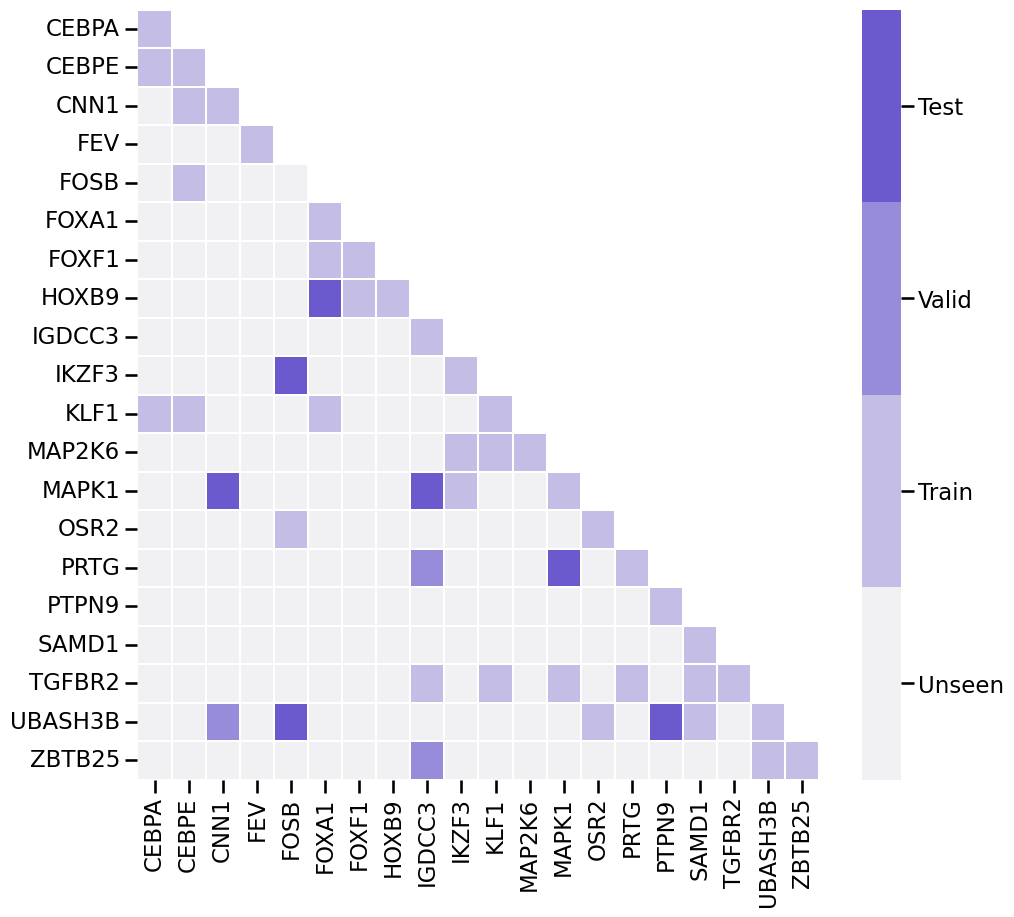

In [9]:
gene_perturb_trainer = GenePerturbationPrediction(
    config=finetune_config,
    pert_data=pert_data,
    pert_data_eval=pert_data_eval,
    tabula_model=tabula_pl_model,
    wandb_logger=wandb_logger,
    device=params['device'],
    batch_size=data_params['batch_size'],
    gene_ids=gene_ids,
    reverse_perturb=True
    )

gene_perturb_trainer.finetune()